# Pressure, Space, and Disruption in Football

This notebook studies how **defensive pressure translates into ball disruption** using tracking data from the SkillCorner Open Data set.

Rather than measuring pressure through distance thresholds or discrete events, we model pressure as a **continuous, spatial-temporal quantity** derived from player arrival times to the ball. We then evaluate how this pressure predicts **possession loss within a short time window**, and how this relationship varies across **defensive phases of play**.

The objective is not to compare teams directly, but to understand:
- When pressure is most effective
- Which defensive contexts convert pressure into disruption
- How pressure intensity relates to turnover probability

In [247]:
!git clone https://github.com/SkillCorner/opendata

fatal: destination path 'opendata' already exists and is not an empty directory.


In [248]:
!pip install mplsoccer

In [249]:
import sys
from pathlib import Path

SRC_PATH = Path("/content/src")
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

In [250]:
import numpy as np
import pandas as pd
import json

In [251]:
from pitch_control import team_control_vectorised
from pressure import pressure_from_players
from disruption import possession_loss_within_window
from curves import build_pressure_curve

## Data Loading and Preparation

Tracking and phase-of-play data are loaded programmatically from the official SkillCorner Open Data repository at runtime; no data files are stored in this submission.

We load tracking data (10 frames per second) and retain only frames where:
- At least one player is detected
- The ball position is available

A long-format player dataframe is constructed with one row per player per frame, containing spatial coordinates and team identity. This structure allows frame-wise spatial calculations while remaining computationally efficient.

In [252]:
DATA_DIR = Path("/content/opendata/data")

# loading matches and tracking data
with open(DATA_DIR / "matches.json") as f:
    matches = json.load(f)

MATCH_ID = matches[1]["id"]
TRACKING_FILE = DATA_DIR / "matches" / str(MATCH_ID) / f"{MATCH_ID}_tracking_extrapolated.jsonl"
tracking = pd.read_json(TRACKING_FILE, lines = True)

In [253]:
# filtering tracking data to keep only the relevant frames
tracking = tracking[tracking["player_data"].apply(len) > 0]
tracking = tracking[tracking["ball_data"].apply(lambda x: x["x"] is not None)]

In [254]:
# building the players dataframe
rows = []

for _, row in tracking.iterrows():
    frame = row["frame"]
    possession = row["possession"]
    team_in_possession = possession["group"] if possession else None
    for p in row["player_data"]:
        rows.append({
            "frame": frame,
            "player_id": p["player_id"],
            "x": p["x"],
            "y": p["y"],
            "is_detected": p["is_detected"]})

In [255]:
players_df = pd.DataFrame(rows)

In [256]:
# match info
with open(DATA_DIR / "matches" / str(MATCH_ID) / f"{MATCH_ID}_match.json") as f:
    match_info = json.load(f)

In [257]:
players_list = match_info["players"]

In [258]:
players_by_id = {
    p["id"]: p
    for p in players_list}

In [259]:
# linking the players to their teams using team_id and categorising them as home/away players
home_team_id = match_info["home_team"]["id"]
away_team_id = match_info["away_team"]["id"]
home_players = [p for p in players_list if p["team_id"] == home_team_id]
away_players = [p for p in players_list if p["team_id"] == away_team_id]

In [260]:
# improvement: adding team info to the players dataframe

players_df["team_id"] = players_df["player_id"].map(
    lambda pid: players_by_id[pid]["team_id"])

players_df["side"] = players_df["team_id"].map(
    lambda tid: "home" if tid == home_team_id else "away")

## Modelling Pitch Control and Pressure

Pressure is modelled as the **collective ability of defenders to reach the ball**.

For each defender, we estimate an arrival time to the ball based on:
- A fixed reaction time
- Maximum running speed
- Euclidean distance to the ball

Ti = reaction time + [|xi-x| / max speed]

Each defender contributes influence via an exponential decay:

influence = Ii​(x) = exp(−λ⋅Ti​(x)) where Ti is the time-to-arrival.

Total defensive pressure is the sum of all defender influences. This formulation captures:
- Distance
- Numbers around the ball
- Diminishing marginal impact of far players

Pitch control is derived by comparing the summed influence of both teams across pitch locations, expressing control as a relative share of influence; areas where defensive influence dominates indicate regions where pressure is more likely to be converted into disruption.

In [261]:
PITCH_LENGTH = 106
PITCH_WIDTH = 68

NX = 50
NY = 34

x_grid = np.linspace(-PITCH_LENGTH/2, PITCH_LENGTH/2, NX)
y_grid = np.linspace(-PITCH_WIDTH/2, PITCH_WIDTH/2, NY)
X, Y = np.meshgrid(x_grid, y_grid)
grid_points = np.column_stack([X.ravel(), Y.ravel()])

In [262]:
frame_id = players_df["frame"].iloc[0]
frame_players = players_df[players_df["frame"] == frame_id]

In [263]:
home = frame_players[frame_players["side"] == "home"]
away = frame_players[frame_players["side"] == "away"]

In [264]:
home_xy = home[["x", "y"]].values
away_xy = away[["x", "y"]].values

home_control = team_control_vectorised(home_xy, grid_points)
away_control = team_control_vectorised(away_xy, grid_points)

In [265]:
pitch_control_home = home_control / (home_control + away_control)
PC_home = pitch_control_home.reshape(NY, NX)

In [266]:
# ball location
ball = tracking.loc[tracking["frame"] == frame_id, "ball_data"].iloc[0]
ball_xy = np.array([ball["x"], ball["y"]])

In [267]:
# distance from each grid point
dist_to_ball = np.linalg.norm(grid_points - ball_xy, axis=1)

In [268]:
# ball weights
BALL_DECAY = 0.2
ball_weights = np.exp(-BALL_DECAY * dist_to_ball)

In [269]:
PC_home_ball = pitch_control_home * ball_weights

In [270]:
PC_home_ball_grid = PC_home_ball.reshape(NY, NX)

In [271]:
RADIUS = 6.0  # meters
pressure_mask = dist_to_ball < RADIUS

home_pressure = PC_home_ball[pressure_mask].sum()
away_pressure = (1 - PC_home_ball)[pressure_mask].sum()

## Frame-level Pressure Estimation

For every frame:
- The defending team is inferred from possession data
- Defensive pressure is computed relative to the current ball position
- Pressure values are standardised (z-scores) to allow comparison across frames

This results in a continuous pressure signal over time for the entire match.

In [272]:
team_in_possession = tracking.loc[
    tracking["frame"] == frame_id, "possession"].iloc[0]["group"]

In [273]:
if team_in_possession == "home":
    defending = away
else:
    defending = home

defensive_pressure = pressure_from_players(defending, ball_xy)

In [274]:
pressure_frames = []
pressure_series = []

for frame_id in players_df["frame"].unique():
    frame_players = players_df[players_df["frame"] == frame_id]

    ball_xy = tracking.loc[
        tracking["frame"] == frame_id, "ball_data"].iloc[0]

    ball_xy = np.array([ball_xy["x"], ball_xy["y"]])

    possession = tracking.loc[tracking["frame"] == frame_id, "possession"].iloc[0]["group"]

    if possession == "home":
        defending = frame_players[frame_players["side"] == "away"]
    else:
        defending = frame_players[frame_players["side"] == "home"]

    pressure = pressure_from_players(defending, ball_xy)

    pressure_frames.append(frame_id)
    pressure_series.append(pressure)

In [275]:
pressure_series = np.array(pressure_series)
pressure_z = (pressure_series - pressure_series.mean()) / pressure_series.std()

In [276]:
pressure_df = pd.DataFrame({
    "frame": pressure_frames,
    "pressure": pressure_series,
    "pressure_z": pressure_z})

We now aggregate pressure scores by phases of play, we already have the csv file with frame_start and frame_end columns, which we can directly use to link our pressure dataframe

In [277]:
phases = pd.read_csv(DATA_DIR / "matches" / str(MATCH_ID) / f"{MATCH_ID}_phases_of_play.csv")

In [278]:
phase_rows = []

for _, phase in phases.iterrows():
    start = phase["frame_start"]
    end = phase["frame_end"]

    phase_pressure = pressure_df.loc[
        (pressure_df["frame"] >= start) &
        (pressure_df["frame"] <= end),
        "pressure_z"]

    if phase_pressure.empty:
        continue

    phase_rows.append({
        "match_id": phase["match_id"],
        "period": phase["period"],
        "frame_start": start,
        "frame_end": end,
        "duration_seconds": phase["duration"],

        # possession context
        "team_in_possession_id": phase["team_in_possession_id"],
        "attacking_side_id": phase["attacking_side_id"],

        # defensive phase context
        "out_of_possession_phase_type":
            phase["team_out_of_possession_phase_type"],
        "out_of_possession_phase_type_id":
            phase["team_out_of_possession_phase_type_id"],

        # pressure aggregation
        "mean_pressure_z": phase_pressure.mean(),
        "max_pressure_z": phase_pressure.max(),
        "std_pressure_z": phase_pressure.std(),
        "n_frames": len(phase_pressure)})

In [279]:
phase_pressure_df = pd.DataFrame(phase_rows)

In [280]:
assert phase_pressure_df["n_frames"].min() > 0

## Defining Disruption

Disruption is defined as **a loss of possession within the next 3 seconds** (30 frames).

Possession is forward-filled across null frames to avoid false changes caused by stoppages. A frame is marked as disrupted if a possession change occurs within the forward time window.

This definition reflects football reality:
- Pressure does not need to cause an immediate turnover
- Successful pressure often leads to delayed errors

In [281]:
possession_df = tracking[["frame", "possession"]].copy()

possession_df["team_in_possession"] = possession_df["possession"].apply(
    lambda x: x["group"] if x else None)

# forward-filling possession through None frames
possession_df["team_ffill"] = possession_df["team_in_possession"].ffill()

In [282]:
possession_df["next_team"] = possession_df["team_ffill"].shift(-1)
possession_df["possession_change"] = (possession_df["team_ffill"] != possession_df["next_team"]) & possession_df["next_team"].notna()

In [283]:
change_events = possession_df[possession_df["possession_change"]][["frame", "team_ffill", "next_team"]]

In [284]:
FPS = 10
WINDOW = 3 * FPS  # 30 frames

possession_change_frames = possession_df[possession_df["possession_change"]]["frame"].values

In [285]:
pressure_df = pressure_df.merge(possession_df[["frame", "team_ffill"]],on = "frame", how = "left")

In [286]:
pressure_df["disruption"] = pressure_df.apply(
    lambda r: possession_loss_within_window(
        r["frame"],
        r["team_ffill"],
        change_events,
        WINDOW),axis=1)

## Aggregating by Defensive Phase

Pressure and disruption are aggregated using pre-defined phases of play provided by SkillCorner.

For each phase, we compute:
- Mean and maximum pressure
- Disruption rate (share of frames leading to possession loss)
- Whether any disruption occurred

This allows pressure effectiveness to be evaluated **within tactical contexts**, such as low blocks, transitions, or set plays.

In [287]:
phase_disruption_rows = []

for _, phase in phases.iterrows():
    start = phase["frame_start"]
    end = phase["frame_end"]

    phase_frames = pressure_df.loc[
        (pressure_df["frame"] >= start) &
        (pressure_df["frame"] <= end)]

    if phase_frames.empty:
        continue

    phase_disruption_rows.append({
        "out_of_possession_phase_type":
            phase["team_out_of_possession_phase_type"],

        # pressure summaries
        "mean_pressure_z": phase_frames["pressure_z"].mean(),
        "max_pressure_z": phase_frames["pressure_z"].max(),

        # disruption metrics
        "disruption_rate": phase_frames["disruption"].mean(),
        "any_disruption": int(phase_frames["disruption"].any()),

        # metadata
        "n_frames": len(phase_frames),
        "duration_seconds": phase["duration"]})

In [288]:
phase_disruption_df = pd.DataFrame(phase_disruption_rows)

In [289]:
# Pressure Efficiency: To compare phases with different pressure intensities, we define: Pressure Efficiency = (Disruption Rate)\(Mean Pressure)
# This measures how effectively pressure converts into disruption, rather than how intense the pressure is.
# High efficiency indicates phases where relatively little pressure causes frequent turnovers.

phase_disruption_df["pressure_efficiency"] = (
    phase_disruption_df["disruption_rate"] /
    phase_disruption_df["mean_pressure_z"].clip(lower=0.01))

In [290]:
phase_disruption_df.groupby("out_of_possession_phase_type")[["mean_pressure_z", "disruption_rate", "any_disruption", "pressure_efficiency"]].mean().sort_values("pressure_efficiency", ascending=False)

,mean_pressure_z,disruption_rate,any_disruption,pressure_efficiency
out_of_possession_phase_type,,,,
defending_direct,-0.326325,0.158138,0.355556,15.521600
chaotic,0.283358,0.265859,0.460000,10.347533
defending_set_play,0.337574,0.260779,0.416667,10.217604
medium_block,0.017224,0.213216,0.480519,8.058087
low_block,0.310966,0.259991,0.542373,6.811733
defending_quick_break,0.698282,0.225657,0.500000,6.008765
high_block,-0.017269,0.126942,0.472222,4.550616
defending_transition,0.104227,0.154647,0.428571,0.507592


## Pressure–Disruption Relationship

Pressure values are binned into quantiles, and the probability of disruption is calculated for each bin.

This produces a temporal response curve showing how turnover probability evolves as pressure increases.

We also compute phase-specific curves to examine how different defensive structures modify the pressure–disruption relationship.

In [291]:
curve_df = build_pressure_curve(pressure_df)

/content/src/curves.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



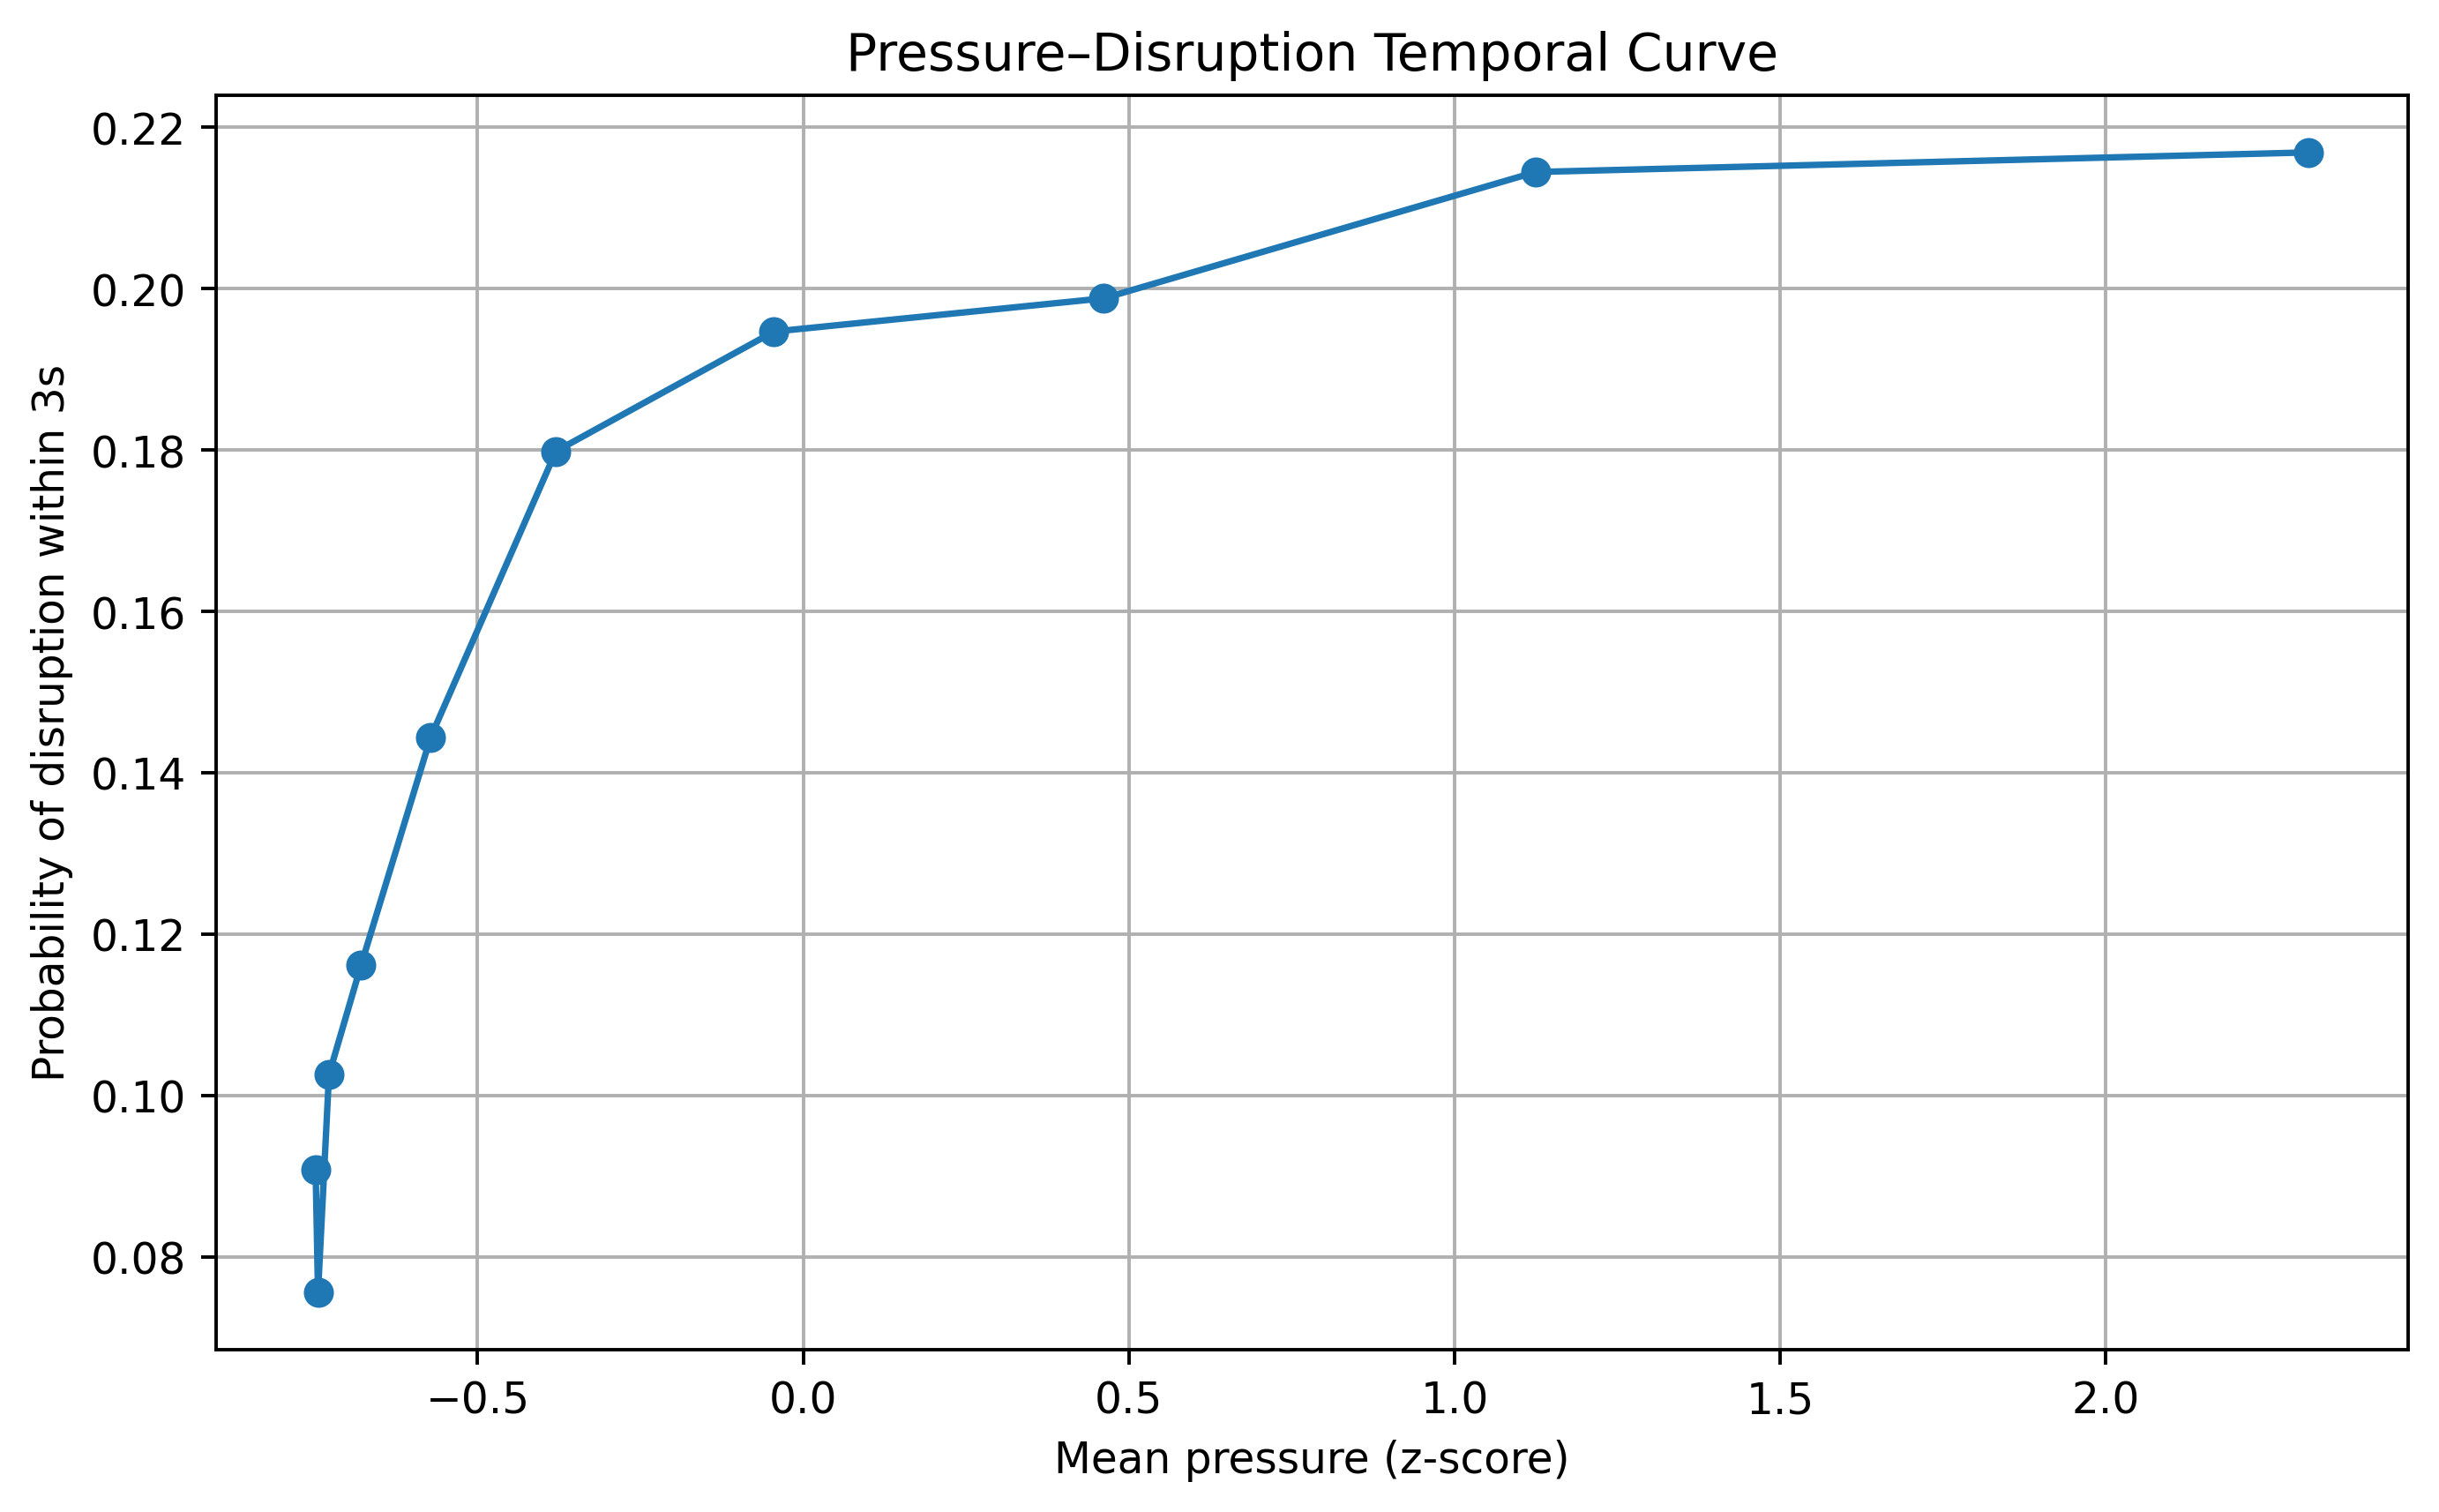

In [292]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), dpi = 350)
plt.plot(
    curve_df["mean_pressure_z"],
    curve_df["disruption_rate"],
    marker="o")

plt.xlabel("Mean pressure (z-score)")
plt.ylabel("Probability of disruption within 3s")
plt.title("Pressure–Disruption Temporal Curve")
plt.grid(True)

plt.tight_layout()
plt.show()

In [293]:
phase_lookup = []

for _, phase in phases.iterrows():
    phase_lookup.append(pd.DataFrame({
        "frame": np.arange(phase["frame_start"], phase["frame_end"] + 1),
        "out_of_possession_phase_type": phase["team_out_of_possession_phase_type"]
    }))

phase_lookup_df = pd.concat(phase_lookup, ignore_index=True)

In [294]:
pressure_df = pressure_df.merge(
    phase_lookup_df,
    on = "frame",
    how = "left")

In [295]:
pressure_df["pressure_bin"] = pd.qcut(pressure_df["pressure_z"], q = 10, duplicates="drop")

In [296]:
pressure_df["pressure_bin_mid"] = pressure_df["pressure_bin"].apply(lambda x: x.mid)

In [297]:
phase_curves = (
    pressure_df
    .groupby(["out_of_possession_phase_type", "pressure_bin_mid"])
    .agg(
        disruption_rate = ("disruption", "mean"),
        n_frames = ("disruption", "size"),
        mean_pressure_z = ("pressure_z", "mean"))
    .reset_index())

/tmp/ipython-input-485487122.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [308]:
# filtering out noise

phase_curves = phase_curves[phase_curves["n_frames"] > 100]

In [309]:
import plotly.express as px

fig = px.line(
    phase_curves,
    x = "pressure_bin_mid",
    y = "disruption_rate",
    color = "out_of_possession_phase_type",
    markers = True,
    title = "Pressure → Disruption Curves by Defensive Phase",)

fig.update_layout(
    xaxis_title = "Pressure (z-score bins)",
    yaxis_title = "Probability of Disruption within 3s",
    hovermode = "x unified",
    template = "plotly_dark")

fig.show()

## Key Findings

- Disruption probability increases monotonically with pressure on a general level. However, the relationship is not necessarily monotonic when studied phase-wise.
- The marginal gain from pressure is highest at low–moderate levels of pressure for low, medium, and high blocks.
- Certain phases (e.g. chaotic) seem to achieve higher disruption with less pressure, and experience a sharp drop as pressure increases (before increasing again), this may seem strange, but shows that just the right amount of pressure is needed to maximise probability of disruption. In chaotic (and even medium-block) phases, excessive pressure leads to lesser chances of disruption, and the 'sweet spot' must be discovered. Again, this isn't a predictive model, it simply works on conditional probability, and different team structures might have different 'sweet spots' across different matches.
- Simply put, high pressure alone does not guarantee effectiveness, context matters.

These results suggest that **how** and **when** pressure is applied is more important than sheer intensity.

## Conclusion

This framework provides a reusable, data-driven method to quantify defensive pressure and evaluate its effectiveness across tactical phases.

By linking spatial pressure to delayed disruption, the model moves beyond event-based analysis and captures the continuous nature of defensive influence in football.

Future extensions could include:
- Multi-match aggregation
- Team-level or even player-level pressure attribution
- Integration with expected threat models
